# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run shared detector on bash
```bash
python3 /home/kiro-ros/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_CAM = False
ENABLE_DETECT = False
ENABLE_O3D = True

CONNECT_INDY = False
CONNECT_MOBILE = False

CONNECT_TASK_PLANNER = False
VISUALIZE = False
VERBOSE = False
PLANNING_MULTIPROC = True
N_AGENTS = 10
NODE_TRIAL_MAX = N_AGENTS * 2
MAX_SOL_NUM = 5
BASE_COST_CUT = 110

TIMEOUT_MOTION = 0.5
TIMEOUT_FULL = 5

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.08, 0.32]
# TOOL_OFFSET = 0.01
TOOL_OFFSET = 0.01 # tested one
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

IP_CUR = "192.168.0.10"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.10
Mobile ROB IP: 192.168.0.102


In [2]:
from demo_proto.TaskExecuteServer import serve_on_thread

In [3]:
if CONNECT_TASK_PLANNER:
    servicer = serve_on_thread()

In [4]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections

from utils.stream_server import *
from utils.detection_util import *


from pkg.utils.shared_function import *
clear_channels_on("kiromobilemap")

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=(1,1,1,0.2), display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 8, -7, 7, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, 
# face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=True, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "Z"), (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(RobotType.indy7, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(DATASET_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene, node_trial_max=NODE_TRIAL_MAX)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)


add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, 
                       tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']

if CONNECT_MOBILE:
    assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"
    
if CONNECT_CAM:
    camgen = CameraGenerator()

connection command:
kmb0: True
indy1: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Loaded: indy7-frontZ-PRQ.pkl
Loaded: indy7-frontX-PRQ.pkl
Loaded: indy7-upZ-PRQ.pkl
Loaded: indy7-downZ-PRQ.pkl


#### 0.1.2 Load environment map

In [5]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR, CONNECT_MOBILE)
            
VALID_BOX_SCALE = 0.8
VALID_SCORE_CUT = 50
kmb.coster = (lambda Q: 
                  np.max(
                      kmm.get_box_costs(mobile_box, Q, kmm.T_bi, kmm.cost_im, kmm.resolution, 
                                        scale=VALID_BOX_SCALE)))
kmb.cost_cut = VALID_SCORE_CUT
kmb.gscene = gscene

kmm.init_node(timeout=10)

In [6]:
pole_pt_list, pole_res = kmm.update_map(gscene, crob, MOBILE_BASE, timeout=100)

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

In [7]:
from utils.shared_detector import SharedDetector
sd = SharedDetector()
if ENABLE_DETECT:
    sd.init()

In [8]:
if CONNECT_TASK_PLANNER:
    while servicer.object_info_running.object_id < 0:
        time.sleep(1)

#### 1.1.1 Move to bed-seek pose 

In [9]:
Q_CUR = kmb.get_qcur()

VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

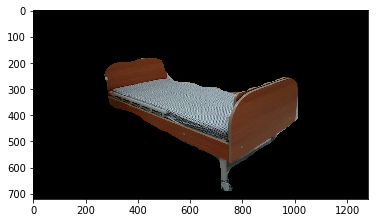

In [10]:
turn_dir = 1
Q0 = np.rad2deg(VIEW_POSE_EXT[6:])
dQ = np.zeros(6)
while True:
    # Take a picture again after rotate
    if CONNECT_CAM:
        rdict = camgen.stream_capture_image(obj_type="bed", crob=crob)
    else:
        rdict, VIEW_POSE_EXT = load_rdict("bed")
        

    cdp = rdict2cdp(rdict)
        
    
    if ENABLE_DETECT:
        # Output of inference(mask for detected table)
        mask_out = sd.inference(color_img=rdict['color'])
        cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed.png"), mask_out)
    else:
        mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed.png"))[:,:,0]
        
    if np.any(mask_out):
        cdp_masked = apply_mask(cdp, mask_out)
        plt.imshow(cdp_masked.color[:,:,[2,1,0]])
        break
    if CONNECT_INDY:
        with indy:
            turn_dir *= -1
            dQ = np.add(dQ, [5,0,0,0,0,0])
            Qto = Q0+turn_dir*dQ
            Qto[0] = (Qto[0]+180/2)%180-180/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
            VIEW_POSE_EXT[6:] = np.deg2rad(indy.get_joint_pos())

#### 1.1.2  detect bed and add to the scene

In [11]:
from pkg.utils.utils import *
gtimer = GlobalTimer.instance()

In [12]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_bc_bed_view = np.copy(T_bc)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)
if ENABLE_O3D:
    icp_bed = MultiICP(model=MODEL_DIR + '/bed/bed_final_rot_res.stl', 
                       Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]))
    # Try ICP1
    if np.any(mask_out):
        pcd = icp_bed.add_image(cdp_masked, Tc=None, ratio=0.2)

        Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi/2)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.5,0,-0.6)))
        
        with gtimer.block("ICP"):
            Tbs1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.15, visualize=VISUALIZE)
            Tbs2, fitness2 = icp_bed.compute_ICP(None, thres=0.15, visualize=VISUALIZE)
        
    # Better result is adopted
    T_co_bed = Tbs1 if fitness1 > fitness2 else Tbs2
    T_bo_bed = np.matmul(T_bc, T_co_bed)
    
    bed_center = T_bo_bed[:3,3]
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    Tbm = gscene.get_tf(MOBILE_BASE, VIEW_POSE_EXT)
    Tmo = np.matmul(SE3_inv(Tbm), T_bo_new)
    if Tmo[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))
    if VISUALIZE: # show final result
        icp_bed.draw(np.matmul(T_cb, gscene.NAME_DICT["bed_vis"].get_tf(VIEW_POSE_EXT)))
    
else:
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))

bed_vis = gscene.NAME_DICT["bed_vis"]

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.999686e-01, inlier_rmse=4.573751e-02, and correspondence_set size of 5740
Access transformation to get result.
Transformation is:
[[ 0.70701907 -0.08820593  0.70167208 -1.1477407 ]
 [-0.32385435 -0.92242311  0.21036608  0.37287545]
 [ 0.62868303 -0.3759724  -0.68073663  3.36955537]
 [ 0.          0.          0.          1.        ]]
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
Apply point-to-point ICP
registration::RegistrationResult with fitness=5.774537e-01, inlier_rmse=7.776751e-02, and correspondence_set size of 3683
Access transformation to get result.
Transformation is:
[[ 0.34192117  0.48162369  0.80692536 -1.66080036]
 [ 0.59794985 -0.77392532  0.20855592  0.06099039]
 [ 0.72494544  0.41

In [13]:
# Front ICP - refine the position of bed
VISUALIZE = False
T_bc_new = viewpoint.get_tf(VIEW_POSE_EXT)
T_bo_new = bed_vis.get_tf(VIEW_POSE_EXT)
Tco_guess = np.matmul(SE3_inv(T_bc_bed_view), T_bo_new)
T_cc = np.matmul(SE3_inv(T_bc_bed_view), T_bc_new)

with gtimer.block("ICP"):
    Tbs_f, fitness_f = icp_bed.compute_front_ICP(
        T_cc, To=Tco_guess, thres=0.15, visualize=VISUALIZE)


T_bo_bed = np.matmul(T_bc, Tbs_f)
bed_center = T_bo_bed[:3,3]
T_bo_new = align_z(T_bo_bed)
bed_rpy = Rot2rpy(T_bo_new[:3,:3])

# adjust
bed_center[2]=0
Tbm = gscene.get_tf(MOBILE_BASE, VIEW_POSE_EXT)
Tmo = np.matmul(SE3_inv(Tbm), T_bo_new)
if Tmo[0,0] > 0:
    bed_rpy[2] += np.pi
move_bed(gscene, bed_center, bed_rpy)

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.185540e-01, inlier_rmse=4.259721e-02, and correspondence_set size of 2109
Access transformation to get result.
Transformation is:
[[ 0.71342114 -0.07456491  0.69675702 -1.17005374]
 [-0.30350603 -0.92909702  0.21133562  0.37637947]
 [ 0.63159667 -0.36224125 -0.68546838  3.35435284]
 [ 0.          0.          0.          1.        ]]


### 1.2 Detect Closet

#### 1.2.1  move to full view position

##### calc fule view pose

In [14]:
VIEW_MOVED = np.deg2rad([  0., 60.,  -60.,  -0.,  -100., 0])
# VIEW_MOVED = np.deg2rad([  0., -10.,  -0.,  -0.,  -100., 0])
VIEW_POSE_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if ENABLE_O3D:
    h_fov_hf = np.arctan2(cdp.intrins[0], 2*cdp.intrins[2])
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(
        cdp2pcd(cdp), cdp2pcd(cdp_masked), T_bc, T_bo, 
        bed_dims=bed_mat.dims, visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    h_fov_hf = np.pi/4
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_refs = [150]
elif CLOSET_LOCATION == "RIGHT":       
    angle_refs = [-150]
    
bed_dim = np.linalg.norm(bed_mat.dims)
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 2.5
for angle_ref in angle_refs:
    for _ in range(100):
        angle_view = angle_ref + np.random.uniform(-10, 10)
        dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/4
        Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
        Tbs = np.matmul(Tbs, 
                        SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
        Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                        SE3(np.identity(3), (-dist_view, 0,0)))
        Tbc = np.matmul(Tbs, Tsc)
        Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
        Tmc[:3,:3] = np.identity(3)
        Tbm = np.matmul(Tbc, SE3_inv(Tmc))
        full_view_ext = np.copy(VIEW_POSE_EXT)
        full_view_ext[:2] = Tbm[:2,3]
        full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
        gscene.show_pose(full_view_ext)
        res = kmb.check_valid(full_view_ext[:6])
        if res:
            VIEW_MOVED_EXT = full_view_ext
            print("Full view loc: {}".format(np.round(VIEW_MOVED_EXT[:3], 2)))
            break
    if res:
        break

CLOSET on LEFT
Full view loc: [ 5.98 -1.99 -1.95]


##### move to full view pose

In [15]:
if CONNECT_INDY and CONNECT_MOBILE:
    gscene.show_pose(crob.get_real_robot_pose())
    print("real_robot_pose: {}".format(
        np.round(crob.get_real_robot_pose(), 2)))

In [16]:
# VIEW_MOVED = VIEW_POSE
# VIEW_MOVED_EXT = VIEW_POSE_EXT
# CLOSET_LOCATION = "LEFT"

In [17]:
gscene.show_pose(VIEW_MOVED_EXT)

In [18]:
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    kmb.joint_move_make_sure(VIEW_MOVED_EXT[:6])
    VIEW_MOVED_EXT = crob.get_real_robot_pose()
if not CONNECT_INDY:
    VIEW_MOVED_EXT[6:] = VIEW_MOVED.copy()
gscene.show_pose(VIEW_MOVED_EXT)
print("VIEW_MOVED_EXT: {}".format(
    np.round(VIEW_MOVED_EXT, 2)))

VIEW_MOVED_EXT: [ 5.98 -1.99 -1.95  0.    0.    0.    0.    1.05 -1.05 -0.   -1.75  0.  ]


#### 1.2.2 redetect bed

Apply point-to-point ICP
registration::RegistrationResult with fitness=6.055870e-01, inlier_rmse=4.407859e-02, and correspondence_set size of 3642
Access transformation to get result.
Transformation is:
[[-0.99873518  0.02958088  0.04065746  5.14727128]
 [ 0.03991106 -0.02540015  0.99888035 -4.79056317]
 [ 0.03058046  0.99923961  0.02418742 -0.09237422]
 [ 0.          0.          0.          1.        ]]


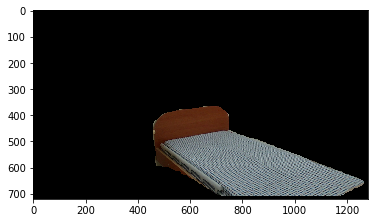

In [19]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
# capture image of full view
if CONNECT_CAM:
    rdict = camgen.stream_capture_image(obj_type="full_view", crob=crob)
    
else:
    rdict, VIEW_MOVED_EXT = load_rdict("full_view")
    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    gscene.show_pose(VIEW_MOVED_EXT)
    
cdp = rdict2cdp(rdict)

if ENABLE_DETECT:
    # Output of inference(mask for detected table)
    mask_out = sd.inference(color_img=cdp.color)
    cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed_re.png"), mask_out)
else:
    mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed_re.png"))[:,:,0]
    
if np.any(mask_out):
    cdp_masked = apply_mask(cdp, mask_out)
    plt.imshow(cdp_masked.color[:,:,[2,1,0]])

    icp_bed.clear()
    pcd = icp_bed.add_image(cdp_masked, Tc=T_bc, ratio=0.2)
    T_bs_pre = gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT)
    T_bo_bed, fitness = icp_bed.compute_ICP(To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
#         # front_ICP
#         T_bo_bed, fitness = icp_bed.compute_front_ICP(T_bc, To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
    # adjust
    T_bo_bed[2]=0
    T_bo_bed[:3, :3]=Rot_axis(3, Rot2axis(T_bo_bed[:3, :3], 3))
    move_bed(gscene, T_bo_bed[:3,3], Rot2rpy(T_bo_bed[:3,:3]))

    if VISUALIZE: # show final result
        icp_bed.draw(gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT))
else:
    raise(RuntimeError("bed not detected"))

#### 1.2.3  detect and add closet

In [20]:
VISUALIZE = False
if ENABLE_O3D:
    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))
    
    if CONNECT_CAM:
        rdict = camgen.stream_capture_image(obj_type="top_table", crob=crob)
    else:
        rdict, VIEW_MOVED_EXT = load_rdict("top_table")

    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    
    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)
    
    
    pcd_masked = mask_boxes(pcd_closet, 
                        boxes=[gscene.NAME_DICT["bed_{}_space".format(CLOSET_LOCATION.lower())]], 
                        Q=VIEW_MOVED_EXT, inside=True, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked = mask_boxes(pcd_masked, 
                        boxes=[gscene.NAME_DICT["bed_box"], 
                               gscene.NAME_DICT["bed_wall"], 
                               gscene.NAME_DICT["floor_box"]], 
                        Q=VIEW_MOVED_EXT, inside=False, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
    icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.2)
    
    Tbs = bed_vis.get_tf(VIEW_MOVED_EXT)
    initial_guess = icp_closet.get_initial_by_median(
        Tbs[:3, :3], 
        np.matmul(T_bc[:3,:3], (0,0,0.3))-(0,0,1))
    with gtimer.block("ICP"):
        T_bo, fitness = icp_closet.compute_front_ICP(T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)
    
#     # front_cut_ICP
#     T_bo, fitness = icp_closet.compute_front_cut_ICP("closet",
#                            initial_guess, thres=0.05, visualize=VISUALIZE)
    
    #adjust
    T_bo[2]=0
    T_bo[:3, :3]=Rot_axis(3, Rot2axis(T_bo[:3, :3], 3))
#     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
#     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))
    
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

add_backwall(gscene)

Apply point-to-point ICP
registration::RegistrationResult with fitness=3.164597e-01, inlier_rmse=1.770344e-02, and correspondence_set size of 994
Access transformation to get result.
Transformation is:
[[ 3.67298692e-02  3.47802262e-03  9.99319185e-01  5.39967069e+00]
 [ 9.99324509e-01 -1.33508961e-03 -3.67254182e-02 -4.80008378e+00]
 [ 1.20644882e-03  9.99993060e-01 -3.52471091e-03 -4.79707596e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [21]:
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["bed_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["closet_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["room_box"], 
                    pole_pt_list, VIEW_POSE_EXT, inside=False)
pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res)
gcheck.ignore_always = pole_list

gscene.update_markers_all() 

In [22]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production



## 2. Closet cleaning

### 2.0. Prepare functions

In [23]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

   Use a production WSGI server instead.
 * Debug mode: off


In [24]:
# mplan.reset_log(flag_log=True)
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, 
                           gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

brush_face = change_tool(
    pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, 
    TOOL_NAME, SweepFramer, clearance=CLEARANCE)

Tool Down


In [25]:
adjust_count_list = []
def look_closet_get_offset(gxter, crob, mplan, robot_name, Qref):
    Qref_in = np.copy(Qref)
    Qref = np.copy(Qref)
    for _ in range(5):
        traj, succ = get_look_motion(mplan, robot_name, Qref, 
                                     target_point=gscene.NAME_DICT["closet_leftup"],
                                     com_link=pscene.robot_chain_dict[robot_name]['link_names'][-1],
                                     view_dir=[0,0,1],timeout=1)
        traj_rev = np.array(list(reversed(traj)))

    if not succ:
        look_closet_get_offset.Qref_fail = Qref
        raise(RuntimeError("Get Look Motion Fail"))

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        with indy: # move to look
            crob.move_joint_traj(traj, one_by_one=True)

    time.sleep(1)

    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))

    adjust_count_list.append(1)
    if CONNECT_CAM:
        rdict = camgen.stream_capture_image( 
                                     obj_type="closet_{}".format(len(adjust_count_list)), 
                                     crob=crob)
    else:
        try:
            rdict, Qref = load_rdict("closet_{}".format(len(adjust_count_list)))
            gscene.show_pose(Qref)
        except Exception as e:
            TextColors.YELLOW.println("[WARN] out of saved look refine data")
            print(e)
            Qcur = np.copy(Qref_in)
            Qcur[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                         [0.05, 0.05, 0.05, 0, 0, 0])

            Qtar = np.copy(Qref_in)
            Qtar[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                         [0.05, 0.05, 0.05, 0, 0, 0])
            return Qcur, Qtar

    T_bc, T_bs_closet = viewpoint.get_tf(Qref), gscene.NAME_DICT["closet_vis"].get_tf(Qref)

    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)

    with gtimer.block("masking"):
        pcd_masked = mask_boxes(pcd_closet, 
                            boxes=[gscene.NAME_DICT["closet_box"]], 
                            Q=Qref, inside=True, 
                            merge_rule=np.all, link_ref="base_link")
        pcd_masked = mask_boxes(pcd_masked, 
                            boxes=[gscene.NAME_DICT["bed_box"], 
                                   gscene.NAME_DICT["bed_wall"], 
                                   gscene.NAME_DICT["floor_box"],
                                   gscene.NAME_DICT["back_wall"]], 
                            Q=Qref, inside=False, 
                            merge_rule=np.all, link_ref="base_link")

    with gtimer.block("adding"):
        icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.2)

    initial_guess = gscene.NAME_DICT["closet_vis"].get_tf(Qref)
    with gtimer.block("compute_front_ICP"):
        # front_ICP
        T_bo_close, fitness = icp_closet.compute_front_ICP(
            T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)

    # calculate transform based on obtained points
    pcd_center_prev = pcd_masked.get_center()

    T_bo_p = SE3(T_bo_close[:3,:3], pcd_center_prev)
    T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
    T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
    T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
    T_bo_c_fix[2,3] = 0

    # get Twoff from redetection
    Tbo0, Tbo1 = T_bs_closet, T_bo_c_fix
    Tbw0 = gscene.get_tf(gxter.mobile_link, Qref)
    Tow1 = np.matmul(SE3_inv(Tbo1), Tbw0)
    Tbw1 = np.matmul(Tbo0, Tow1)

    if CONNECT_CAM and CONNECT_MOBILE:
        Qcur = np.copy(Qref)
        Qcur[:2] = Tbw1[:2,3]
        Qcur[2] = Rot2axis(Tbw1[:3,:3], 3)

        Tow0 = np.matmul(SE3_inv(Tbo0), Tbw0)
        Tbw1tar = np.matmul(Tbo1, Tow0)
        Qtar = np.copy(Qref)
        Qtar[:2] = Tbw1tar[:2,3]
        Qtar[2] = Rot2axis(Tbw1tar[:3,:3], 3)
    else:
        Qcur = np.copy(Qref_in)
        Qcur[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
        
        Qtar = np.copy(Qref_in)
        Qtar[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
    return Qcur, Qtar

### 2.1. Greedily execute closet cleaning

In [26]:
VISUALIZE = False
UP_OFFSET = 0.02

In [27]:
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)
        
    indy.collision_policy = POLICY_NO_COLLISION_DETECTION
swp_fin_list = []

Qcur = VIEW_MOVED_EXT
mode_switcher=ModeSwitcherKMB(pscene, push_dist=0.0)

In [28]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.1, margin=0.1)
tplan.node_trial_max = NODE_TRIAL_MAX

brush_face = change_tool(pscene, kmb, ToolDir.up, TOOL_OFFSET+UP_OFFSET, 
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                        timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                        verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_leftup, "front", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_lf, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool UP
Drift = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[INFO] Depart via: [0.2  0.16 0.  ] (101.399993896) <- [0. 0. 0.] (105.793792725)
End up at=[0.203 0.162 0.   ] (0.0 / 0.0)
End up at=[ 6.21  -3.032 -1.608] (0.0 / 0.0)
Apply point-to-point ICP
registration::RegistrationResult with fitness=4.473892e-01, inlier_rmse=1.796183e-02, and correspondence_set size of 1131
Access transformation to get result.
Transformation is:
[[ 0.02455052 -0.04037648  0.99888288  5.48003846]
 [ 0.99928992  0.02955836 -0.02336573 -4.87802885]
 [-0.02858191  0.99874724  0.04107348  0.0081979 ]
 [ 0.          0.          0.          1.        ]]
[PLAN] Adjust base once. ((1.52, -0.327, 1.197), (-0.707, 0.0, 0.707, 0.0)) / ((1.52, -0.28, 1.15), (0.71, 0.01))
[PLAN] Qcur: [ 6.165 -3.078 -1.628]
[PLAN] Qref: [ 6.21  -3.032 -1.608]
[PLAN] tar: [ 6.235 -3.024 -1.645]
End up at=[ 6.235 -3.024 -1.608] (0.0 / 0.0)
Apply point-to-point ICP
registration::RegistrationResult with fitness=4.498624e-01, inlier_rmse=1.7956

In [29]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.1, margin=0.1)
tplan.node_trial_max = NODE_TRIAL_MAX

brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET+UP_OFFSET,
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter.drift)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_leftup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_lu, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, covereds=covereds)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool Down
Drift = [-0.02 -0.01 -0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
End up at=[ 6.105 -3.086 -1.616] (2.22e-16 / 2.22e-16)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.481207e-01, inlier_rmse=1.283004e-02, and correspondence_set size of 800
Access transformation to get result.
Transformation is:
[[ 6.19814666e-02  1.22305695e-02  9.98002355e-01  5.38991776e+00]
 [ 9.98076142e-01  7.60526246e-04 -6.19953695e-02 -4.78713008e+00]
 [-1.51724566e-03  9.99924915e-01 -1.21599011e-02 -1.72551643e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Adjust base once. ((1.52, -0.205, 1.14), (-0.707, 0.0, 0.707, 0.0)) / ((1.52, -0.2, 1.17), (0.71, -0.0))
[PLAN] Qcur: [ 6.092 -3.065 -1.617]
[PLAN] Qref: [ 6.097 -3.091 -1.62 ]
[PLAN] tar: [ 6.105 -3.095 -1.634]
End up at=[ 6.105 -3.095 -1.62 ] (0.0 / 0.0)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.594264e-01, inlier_rmse=1.444646e-02, and cor

======================= terminated 7: required answers acquired  (1.2/5.0) ===============================
======================= terminated 8: Stop called from other agent  (1.2/5.0) ===============================
======================= terminated 3: Stop called from other agent  (1.3/5.0) ===============================
======================= terminated 2: Stop called from other agent  (1.3/5.0) ===============================
======================= terminated 1: Stop called from other agent  (1.3/5.0) ===============================
======================= terminated 4: Stop called from other agent  (1.4/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
Goal reached
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face


In [30]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_rightup, HEIGHT=0.2, margin=0.1)
tplan.node_trial_max = NODE_TRIAL_MAX * 2

brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET+UP_OFFSET,
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter.drift)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_rightup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_ru, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool Down
Drift = [-0.    0.01  0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
End up at=[ 5.967 -3.537 -1.627] (0.0 / 0.0)
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.290816e-01, inlier_rmse=1.492536e-02, and correspondence_set size of 1514
Access transformation to get result.
Transformation is:
[[ 0.06738932  0.0181682   0.99756132  5.44218445]
 [ 0.99759135  0.01524448 -0.06766899 -4.8092155 ]
 [-0.01643673  0.99971872 -0.01709713  0.0139386 ]
 [ 0.          0.          0.          1.        ]]
[PLAN] Adjust base once. ((1.87, -0.43, 0.84), (-0.707, 0.0, 0.707, 0.0)) / ((1.87, -0.45, 0.88), (0.71, 0.01))
[PLAN] Qcur: [ 5.985 -3.494 -1.636]
[PLAN] Qref: [ 5.966 -3.53  -1.62 ]
[PLAN] tar: [ 5.94  -3.522 -1.649]
End up at=[ 5.94  -3.522 -1.62 ] (0.0 / 0.0)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.831887e-01, inlier_rmse=1.658512e-02, and correspondence_set size of 1203
Access transformation to get result.
Transfo

In [31]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(
    closet_down, HEIGHT=0.05, margin=0.1, axis="xy")

brush_face = change_tool(pscene, kmb, ToolDir.up, TOOL_OFFSET,
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter.drift)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                        timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                        verbose=VERBOSE, max_solution_count=MAX_SOL_NUM, show_motion=True)

gxter.get_division_dict(closet_down, "front", "Z", None)
gxter.init_base_divs(Qcur)

snode_schedule_list_lf, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool UP
Drift = [-0.01 -0.02  0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
End up at=[ 6.228 -3.478 -1.626] (0.0 / 0.0)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.855013e-01, inlier_rmse=1.712546e-02, and correspondence_set size of 1456
Access transformation to get result.
Transformation is:
[[ 1.04598383e-01  1.80011605e-02  9.94351611e-01  5.43753656e+00]
 [ 9.94513304e-01 -3.46929892e-03 -1.04552586e-01 -4.80844788e+00]
 [ 1.56763509e-03  9.99831947e-01 -1.82652767e-02 -6.51924899e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Adjust base once. ((0.5, -0.468, 0.74), (-0.707, 0.0, 0.707, 0.0)) / ((0.5, -0.48, 0.74), (0.71, 0.01))
[PLAN] Qcur: [ 6.235 -3.486 -1.66 ]
[PLAN] Qref: [ 6.221 -3.487 -1.62 ]
[PLAN] tar: [ 6.247 -3.496 -1.618]
End up at=[ 6.247 -3.496 -1.62 ] (0.0 / 0.0)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.891856e-01, inlier_rmse=1.800339e-02, and correspondence_

======================= terminated 2: node queue empty 2th  (2.5/5.0) ===============================
======================= terminated 1: node queue empty 3th  (2.5/5.0) ===============================
======================= terminated 5: node queue empty 4th  (2.6/5.0) ===============================
======================= terminated 3: node queue empty 5th  (2.7/5.0) ===============================
======================= terminated 9: node queue empty 6th  (2.7/5.0) ===============================
======================= terminated 6: node queue empty 7th  (2.8/5.0) ===============================
======================= terminated 4: node queue empty 8th  (2.8/5.0) ===============================
======================= terminated 8: node queue empty 9th  (2.8/5.0) ===============================
======================= terminated 7: node queue empty 10th  (2.8/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]

Cannot display motion in multiprocess
Use 10/36 agents
======================= terminated 1: node queue empty 1th  (3.1/5.0) ===============================
======================= terminated 2: node queue empty 2th  (3.2/5.0) ===============================
======================= terminated 0: node queue empty 3th  (3.2/5.0) ===============================
======================= terminated 4: node queue empty 4th  (3.3/5.0) ===============================
======================= terminated 6: node queue empty 5th  (3.3/5.0) ===============================
======================= terminated 3: node queue empty 6th  (3.3/5.0) ===============================
======================= terminated 9: node queue empty 7th  (3.4/5.0) ===============================
======================= terminated 7: node queue empty 8th  (3.4/5.0) ===============================
======================= terminated 8: node queue empty 9th  (3.5/5.0) ===============================
======================= ter

Goal reached
======================= terminated 1: required answers acquired  (1.6/5.0) ===============================
======================= terminated 0: Stop called from other agent  (1.7/5.0) ===============================
======================= terminated 4: Stop called from other agent  (1.8/5.0) ===============================
======================= terminated 2: Stop called from other agent  (1.9/5.0) ===============================
======================= terminated 8: Stop called from other agent  (2.0/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
Goal reached
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
Drift = [-0.02 -0.   -0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
En

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
======================= terminated 8: required answers acquired  (1.2/5.0) ===============================
Goal reached
Goal reached
======================= terminated 7: required answers acquired  (1.2/5.0) ===============================
======================= terminated 4: required answers acquired  (1.2/5.0) ===============================
Goal reached
======================= terminated 5: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 9: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 2: required answers acquired  (1.5/5.0) ===============================
Goal reached
======================= terminated 0: Stop called from other agent  (1.5/5.0) ===============================
======================= terminated 1: required answers acquired  (1.5/5.0) =================

In [32]:
gtimer.reset(scale=1, timeunit='s', stack=True)
brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET, 
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gscene.add_virtual_guardrail(
    closet_down, HEIGHT=0.1, margin=0.1, axis="xy")
tplan.node_trial_max = NODE_TRIAL_MAX * 2

gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter.drift)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION*2, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_down, "down", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(
    Qcur, -1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, 
    covereds=covereds)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool Down
Drift = [ 0.    0.01 -0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
End up at=[ 6.323 -3.359 -1.619] (2.22e-16 / 2.22e-16)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.539677e-01, inlier_rmse=1.530276e-02, and correspondence_set size of 877
Access transformation to get result.
Transformation is:
[[ 0.04058909  0.02833892  0.99877396  5.41982555]
 [ 0.99915948 -0.00688431 -0.04040942 -4.81417875]
 [ 0.00573071  0.99957467 -0.02859452 -0.008984  ]
 [ 0.          0.          0.          1.        ]]
[PLAN] Adjust base once. ((0.5, -0.565, 0.878), (-0.707, 0.0, 0.707, -0.0)) / ((0.5, -0.54, 0.88), (0.71, 0.01))
[PLAN] Qcur: [ 6.298 -3.352 -1.647]
[PLAN] Qref: [ 6.325 -3.354 -1.62 ]
[PLAN] tar: [ 6.337 -3.392 -1.577]
End up at=[ 6.337 -3.392 -1.62 ] (0.0 / 0.0)
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.085714e-01, inlier_rmse=1.621491e-02, and correspondence_set size of 1168
Access transformation to get resul

binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
get_best_base_divs: 	0.0 s/2 = 0.0 s (0.009/0.011)
move_base: 	0.6 s/1 = 0.6 s (0.62/0.62)
offset_fun: 	2.0 s/1 = 2.0 s (2.03/2.03)
masking: 	0.3 s/2 = 0.2 s (0.141/0.162)
adding: 	0.1 s/2 = 0.1 s (0.047/0.059)
compute_front_ICP: 	0.3 s/2 = 0.1 s (0.117/0.155)
adjust_once: 	0.6 s/1 = 0.6 s (0.62/0.62)
update_adjusted_offset: 	2.0 s/1 = 2.0 s (1.979/1.979)
update_base_offset: 	0.0 s/1 = 0.0 s (0.003/0.003)
planning_all: 	4.7 s/1 = 4.7 s (4.695/4.695)
test_base_divs: 	4.7 s/2 = 2.3 s (1.824/2.868)
search_loop: 	4.6 s/2 = 2.3 s (1.799/2.784)
initialize_memory: 	0.1 s/2 = 0.0 s (0.011/0.064)
init_search: 	0.0 s/2 = 0

## 3. Bed cleaning

In [29]:
BED_OFFSET = 0.03

brush_face = change_tool(pscene, kmb, ToolDir.down, 
                         TOOL_OFFSET + BED_OFFSET, 
                         TIP_LINK, TOOL_NAME, 
                         SweepFramer, clearance=CLEARANCE)

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.05, margin=0.05)
gscene.add_virtual_guardrail(closet_rightup, HEIGHT=0.05, margin=0.05)
gscene.add_virtual_guardrail(closet_down, HEIGHT=0.05, margin=0.05, axis="xy")

Tool Down


In [30]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, 
                       drift=None)
tplan.node_trial_max = NODE_TRIAL_MAX

gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

covereds_all = []
for _ in range(1):
    gxter.get_division_dict(bed_mat, "front", "X", EE_HEIGHT, xout_cut=True)
    gxter.init_base_divs(Qcur)
    # gxter.mark_tested(None, None, covereds_all, [])
    snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(
        Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, covereds=covereds_all)
    covereds_all = sorted(set(covereds_all+covereds))
    gxter.test_clear()
    len_covered, len_all = len(covereds_all), len(gxter.surface_div_centers)
    print("########################### TRIAL ONCE DONE ( {} / {} )########################".format(len_covered, len_all))
    if len_covered >= len_all:
        break
    print(gtimer)
gscene.clear_virtuals()

('Height Reference: ', 0.5420000145435333)
Drift = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[INFO] Depart via: [ 6.22 -2.97 -1.61] (41.0) <- [ 6.23 -3.02 -1.61] (51.0)
End up at=[ 6.222 -2.973 -1.608] (0.0 / 0.0)
[INFO] Approach through: [ 3.29 -3.81 -0.04] (1.0) -> [ 3.56 -3.73 -0.04] (102.0)
End up at=[ 3.293 -3.809 -0.04 ] (6.94e-18 / 6.94e-18)
End up at=[ 3.556 -3.726 -0.04 ] (6.94e-18 / 6.94e-18)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.481207e-01, inlier_rmse=1.383035e-02, and correspondence_set size of 800
Access transformation to get result.
Transformation is:
[[ 5.62836477e-02  1.54353366e-02  9.98295500e-01  5.38698288e+00]
 [ 9.98411353e-01  1.76518671e-03 -5.63174723e-02 -4.79067072e+00]
 [-2.63145708e-03  9.99879310e-01 -1.53114641e-02 -1.19775910e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Adjust base once. ((-0.02, 1.178, -0.66), (0.0, 0.0, 0.707, -0.707)) / ((-0.0, 1.22, -0.66), (0.71, -0.7))
[PLAN] Qcur: 

Goal reached
======================= terminated 2: required answers acquired  (2.1/5.0) ===============================
[ERROR] Non-joined subprocesses: [9]
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [8]
[PLAN] Try idc (8,)
Use 10/36 agents
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
======================= terminated 5: required answers acquired  (1.2/5.0) ===============================
Goal reached
======================= terminated 6: required answers acquired  (1.2/5.0) ===============================
Goal reached
======================= terminated 7: required answers acquired  (1.2/5.0) ===============================
Goal reached
======================= terminated 9: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 0: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= te

Goal reached
======================= terminated 7: required answers acquired  (1.9/5.0) ===============================
Goal reached
Goal reached
======================= terminated 5: required answers acquired  (1.9/5.0) ===============================
======================= terminated 8: required answers acquired  (1.9/5.0) ===============================
Goal reached
======================= terminated 1: required answers acquired  (2.1/5.0) ===============================
======================= terminated 3: Stop called from other agent  (2.2/5.0) ===============================
Goal reached
======================= terminated 2: required answers acquired  (2.4/5.0) ===============================
Goal reached
======================= terminated 0: required answers acquired  (2.5/5.0) ===============================
[ERROR] Non-joined subprocesses: [9]
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [17]
[PLAN] Try idc (17,)
Use 10/36

binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
Drift = [0.02 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
[INFO] Depart via: [ 3.29 -3.69 -0.04] (1.0) <- [ 3.54 -3.75 -0.04] (102.0)
End up at=[ 3.294 -3.694 -0.04 ] (6.94e-18 / 6.94e-18)
[INFO] Approach through: [ 6.18 -3.48  3.09] (102.0) -> [ 5.91 -3.51  3.09] (109.0)
[INFO] Approach through: [ 6.2  -3.48  3.09] (102.0) -> [ 6.18 -3.48  3.09] (102.0)
[INFO] Approach through: [ 6.21 -3.51  3.09] (102.0) -> [ 6.2  -3.48  3.09] (102.0)
End up at=[ 6.205 -3.51   3.095] (0.0 / 0.0)
End up at=[ 6.202 -3.483  3.095] (0.0 / 0.0)
End up at=[ 6.183 -3.484  3.095] (0.0 / 0.0)
End up at=[ 5.912 -3.509  3.095] (0.0 / 0.0)
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.926621e-01, inlier_rmse=1.449449e-02, and correspondence_set size of 686
Access transformation to get result.
Transformation is:
[[ 0.06632301 -0.04290611  0.99687528  5.45536

[ERROR] Non-joined subprocesses: [5]
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [9]
[PLAN] Try idc (9,)
Use 10/36 agents
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
======================= terminated 8: required answers acquired  (1.5/5.0) ===============================
Goal reached
======================= terminated 1: required answers acquired  (1.5/5.0) ===============================
Goal reached
======================= terminated 3: required answers acquired  (1.6/5.0) ===============================
Goal reached
======================= terminated 2: required answers acquired  (1.6/5.0) ===============================
Goal reached
======================= terminated 4: required answers acquired  (1.7/5.0) ===============================
Goal reached
======================= terminated 5: required answers acquired  (1.7/5.0) ===============================
Goal reached
======================= te

======================= terminated 9: required answers acquired  (1.6/5.0) ===============================
======================= terminated 6: required answers acquired  (1.6/5.0) ===============================
======================= terminated 3: Stop called from other agent  (1.7/5.0) ===============================
======================= terminated 2: Stop called from other agent  (1.7/5.0) ===============================
======================= terminated 0: Stop called from other agent  (1.7/5.0) ===============================
======================= terminated 5: Stop called from other agent  (1.8/5.0) ===============================
[ERROR] Non-joined subprocesses: [4]
========================== FINISHED (0.0 / 5.0 s) ==============================]
Goal reached
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing 

======================= terminated 4: Stop called from other agent  (1.7/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
Goal reached
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
No motion for connected robot - playing motion in RVIZ
binder: brush_face
rname: indy1
Drift = [-0.    0.01 -0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
[INFO] Depart via: [ 6.12 -3.44 -1.61] (101.399993896) <- [ 5.73 -3.53 -1.61] (109.590698242)
End up at=[ 6.12  -3.442 -1.611] (0.0 / 0.0)
[INFO] Approach through: [ 6.19 -3.48  3.1 ] (102.0) -> [ 5.92 -3.65  3.1 ] (109.393798828)
[INFO] Depart via: [ 6.21 -3.27 -1.61] (41.0) <- [ 6.12 -3.44 -1.61] (101.399993896)
End up at=[ 6.212 -3.266 -1.611] (0.0 / 0.0)
[INFO] Approach through: [ 6.22 -3.54  3.1 ] (102.0) -> [ 6.19 -3.48  3.1 ] (102.0)
[INFO] 

End up at=[ 3.584 -3.962 -0.04 ] (6.94e-18 / 6.94e-18)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.776977e-01, inlier_rmse=1.684116e-02, and correspondence_set size of 1380
Access transformation to get result.
Transformation is:
[[ 1.09865750e-01  3.02678320e-02  9.93485470e-01  5.40362918e+00]
 [ 9.93885410e-01  7.73069399e-03 -1.10145504e-01 -4.82834108e+00]
 [-1.10141978e-02  9.99511928e-01 -2.92334181e-02  3.02410250e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Line idc [1]
[PLAN] Try idc (1,)
Use 10/36 agents
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
======================= terminated 3: required answers acquired  (1.2/5.0) ===============================
Goal reached
======================= terminated 5: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 7: required answers acquired  (1.3/5.0) =======================

In [31]:
if CONNECT_TASK_PLANNER:
    servicer.mark_task_finished()

* MAX_SOL_NUM 적용 v
* 위 오른쪽 안닦이는 문제 파악 - guardrail 마진 - v
* 아래 닦을 때 위쪽 가운데 바운더리 추가 - v
* 침대 닦을 때 옷장 바운더리 마진 추가 - v
* 위치 보정, 드리프트 코드 검토 - ok - v
* 인디 툴 무게 v
* 툴 조인트 플래닝에 추가?